In [3]:
# Imports
import os
from pathlib import Path
import yaml
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/tmp/Ultralytics/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Settings
YOLO_V8N_VERSION = "8.3.0"
DATASET_PATH = Path("/workspace/dataset")
DATASET_ZIP_PATH = DATASET_PATH / "Human Face Expression.v20i.yolov8.zip"
DATASET_YAML_PATH = DATASET_PATH / "data.yaml"
MODELS_PATH = Path("/workspace/models")
PRETRAINED_MODEL_PATH = MODELS_PATH / "yolo_pretrained.pt"
EXPORT_STATE_PATH = MODELS_PATH / "yolo_state_dict.pth"

In [5]:
# Constants
NUM_COORDS_AND_OBJ_SCORE = 5    # 4 coordinates (x, y, w, h) + 1 object score

In [6]:
# Determine if we should execute on the CPU or GPU
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"   # Apple Silicon (Metal Performance Shaders)
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: cuda


## Download dataset

**Manual step required**: Because Roboflow's API key expires every 24 hours, the easiest way to download the dataset is to manually grab it from Roboflow's site.

1. Sign in or create an account on [Roboflow](https://roboflow.com/).
2. Head to the [Human Face Expression Recognition dataset (v20)](https://universe.roboflow.com/human-face-expression-recognition/human-face-expression/dataset/20) on Roboflow.
3. Click **YOLOv8** under *Popular Download Formats**.
4. In the pop-up window, select **Download dataset** and click **Continue**.
5. In the next window, ensure that *YOLOv8* is selected under *Image and Annotation Format*. Select **Download zip to computer** and click **Continue**.
6. Copy the *.zip* file to the *workspace/dataset/* directory.
7. Run the following cells to unzip the dataset and check it.

In [16]:
# Unzip dataset
with zipfile.ZipFile(DATASET_ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(DATASET_PATH)

In [7]:
# Load the YAML
with open(DATASET_YAML_PATH, "r") as f:
    data_config = yaml.safe_load(f)

# Extract class names
class_names = data_config["names"]
num_classes = len(class_names)

# Display contents
print("data.yaml contents:")
for k, v in data_config.items():
    print(f"{k}: {v}")

data.yaml contents:
train: ../train/images
val: ../valid/images
test: ../test/images
nc: 7
names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
roboflow: {'workspace': 'human-face-expression-recognition', 'project': 'human-face-expression', 'version': 20, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/human-face-expression-recognition/human-face-expression/dataset/20'}


## Download model

In [4]:
# Download model weights (pre-trained on COCO)
!wget https://github.com/ultralytics/assets/releases/download/v{YOLO_V8N_VERSION}/yolov8n.pt -O {PRETRAINED_MODEL_PATH}

--2025-11-07 21:04:52--  https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8n.pt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/521807533/101dd207-c6a9-4ee0-bfeb-34e12d2b8f40?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-07T21%3A48%3A30Z&rscd=attachment%3B+filename%3Dyolov8n.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-07T20%3A47%3A38Z&ske=2025-11-07T21%3A48%3A30Z&sks=b&skv=2018-11-09&sig=fQO2r%2FqX1qD6%2FSVoaf7l8mrYl3HUUNRT4VHigbUDB1g%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MjU0OTc5MiwibmJmIjoxNzYyNTQ5NDkyLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvc

## Prepare model for transfer learning

We want to replace part of the detect head (final layers) with a new set of layers that output classification guesses (logits) for our new set of categories (face expressions) instead of the old COCO classes.

In [8]:
# Load the YOLOv8-nano model (pretrained on COCO dataset)
yolo = YOLO(PRETRAINED_MODEL_PATH)

# Access the underlying nn.Module
model = yolo.model

# Move model to CPU or GPU
model.to(device)

# Print model info
print("Number of parameters:", sum(p.numel() for p in model.parameters()))
print(model)

Number of parameters: 3157200
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): S

The detection head is composed of 3 parts:
* cv2 - outputs the box regression (x, y, w, h)
* cv3 - outputs the class logits: 80 categories for COCO
* dfl - converts discrete bins to continuous boxes (to refine box coordinates)

We want to replace cv3 with a similar set of new layers but output the new class logits (7 face expressions). We'll keep cv2 and dfl the same.

In [9]:
# Get the detection head from the model
detect = model.model[-1]

# Update YOLO head metadata
detect.nc = num_classes
detect.no = num_classes + NUM_COORDS_AND_OBJ_SCORE
detect.nl = len(detect.cv3)  # number of detection layers

# Replace the final 1x1 conv in each classification branch
for seq in detect.cv3:
    # Final part of each module is an 1x1 Conv2d layer for 80x80 input
    last_conv = seq[-1]  
    in_ch = last_conv.in_channels

    # Create new conv layer for 7 classes
    new_conv = torch.nn.Conv2d(in_ch, num_classes, kernel_size=1, stride=1)

    # Initialize weights (Kaiming/He normal initialization)
    torch.nn.init.kaiming_normal_(new_conv.weight, mode='fan_out', nonlinearity='relu')
    if new_conv.bias is not None:
        torch.nn.init.zeros_(new_conv.bias)

    # Replace the old layer
    seq[-1] = new_conv

# Show new cv3 part of detection head
print(detect.cv3)

ModuleList(
  (0): Sequential(
    (0): Conv(
      (conv): Conv2d(64, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): Conv2d(80, 7, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): Sequential(
    (0): Conv(
      (conv): Conv2d(128, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True,

In [10]:
# Disable gradient updates (freeze) all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze cv3 part of the detection head
for name, param in model.named_parameters():
    if "cv3" in name:
        param.requires_grad = True

# Print out trainable layers
trainable = [name for name, p in model.named_parameters() if p.requires_grad]
print("Trainable layers:")
for name in trainable:
    print("  ", name)
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Trainable layers:
   model.22.cv3.0.0.conv.weight
   model.22.cv3.0.0.bn.weight
   model.22.cv3.0.0.bn.bias
   model.22.cv3.0.1.conv.weight
   model.22.cv3.0.1.bn.weight
   model.22.cv3.0.1.bn.bias
   model.22.cv3.0.2.weight
   model.22.cv3.0.2.bias
   model.22.cv3.1.0.conv.weight
   model.22.cv3.1.0.bn.weight
   model.22.cv3.1.0.bn.bias
   model.22.cv3.1.1.conv.weight
   model.22.cv3.1.1.bn.weight
   model.22.cv3.1.1.bn.bias
   model.22.cv3.1.2.weight
   model.22.cv3.1.2.bias
   model.22.cv3.2.0.conv.weight
   model.22.cv3.2.0.bn.weight
   model.22.cv3.2.0.bn.bias
   model.22.cv3.2.1.conv.weight
   model.22.cv3.2.1.bn.weight
   model.22.cv3.2.1.bn.bias
   model.22.cv3.2.2.weight
   model.22.cv3.2.2.bias
Total trainable parameters: 498,021


In [11]:
# Get a list of trainable parameter tensors
trainable_params = [p for n, p in model.named_parameters() if p.requires_grad]

# Define a new optimizer
opt = torch.optim.AdamW(
    trainable_params,
    lr=1e-3,
    weight_decay=1e-4
)

# Print what we'll be training
print(f"Optimizer has {len(opt.param_groups[0]['params'])} parameter tensors.")
print(f"Total trainable params: {sum(p.numel() for p in trainable_params):,}")

Optimizer has 24 parameter tensors.
Total trainable params: 498,021


## Data preprocessing

In [12]:
def preprocess_image(
    img,
    target_w=640,
    target_h=640,
    bg_color=(0, 0, 0),
):
    """Load and preprocess an image for training"""
    # Convert image to RGB
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Calculate new width and height in order to maintain aspect ratio
    h, w = img.shape[:2]
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(round(w * scale)), int(round(h * scale))

    # Resize with aspect ratio maintained
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Compute padding (center the image)
    pad_w, pad_h = target_w - new_w, target_h - new_h
    pad_left, pad_right = pad_w // 2, pad_w - pad_w // 2
    pad_top, pad_bottom = pad_h // 2, pad_h - pad_h // 2

    # Apply border padding (black background)
    img_padded = cv2.copyMakeBorder(
        img_resized,
        pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT,
        value=bg_color,
    )

    return img_padded, scale, pad_left, pad_top

In [31]:
def adjust_bboxes_yolo(
    boxes, 
    orig_w, 
    orig_h, 
    target_w, 
    target_h, 
    scale, 
    pad_left, 
    pad_top,
):
    """Scale YOLO-format bounding boxes after image preprocessing"""
    # Make sure we have boxes
    if len(boxes) == 0:
        return boxes

    # Convert boxes to float32
    boxes = np.array(boxes, dtype=np.float32)

    # Convert from normalized to original pixel coordinates
    cls = boxes[:, 0]
    xc = boxes[:, 1] * orig_w
    yc = boxes[:, 2] * orig_h
    bw = boxes[:, 3] * orig_w
    bh = boxes[:, 4] * orig_h

    # Apply scaling and padding
    xc = xc * scale + pad_left
    yc = yc * scale + pad_top
    bw *= scale
    bh *= scale

    # Convert back to normalized YOLO format (new image dimensions)
    xc /= target_w
    yc /= target_h
    bw /= target_w
    bh /= target_h

    # Re-stack into [cls, xc, yc, bw, bh]
    new_boxes = np.stack([cls, xc, yc, bw, bh], axis=1)
    
    return new_boxes.astype(np.float32)

In [37]:
def img_to_tensor(img):
    """Convert a NumPy/OpenCV image to a normalized PyTorch tensor"""
    # Ensure 3-channel RGB shape
    if img.ndim == 2:
        # Grayscale image (H, W), copy image to all three channels
        img = np.repeat(img[..., None], 3, axis=2)
    elif img.ndim == 3 and img.shape[2] == 1:
        # Single-channel image (H, W, 1), copy image to all three channels
        img = np.repeat(img, 3, axis=2)
    elif img.ndim == 3 and img.shape[2] == 3:
        # Already RGB, do nothing
        pass
    else:
        raise ValueError(f"Unexpected image shape: {img.shape}")
    
    # Convert image to tensor
    img = torch.tensor(img)
    
    # Reorder image (H, W, C) to PyTorch's expected order (C, H, W)
    img = img.permute(2, 0, 1)
    
    # Convert to float and normalize from [0, 255] to [0.0, 1.0]
    img = img.float() / 255.0

    return img

In [43]:
def visualize_sample(img_tensor, labels, class_names=None):
    """Display an image and bounding boxes from the dataset."""
    # Convert normalized tensor in (C, H, W) to uint8 array in (H, W, C)
    img = (img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    # Get height and width
    h, w = img.shape[:2]

    # Draw bounding box and label
    for box in labels.numpy():
        cls, xc, yc, bw, bh = box
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label = f"{int(cls)}"
        if class_names:
            label += f" ({class_names[int(cls)]})"
        cv2.putText(
            img, 
            label, 
            (x1 + 5, y2 - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 
            1.0, 
            (255, 0, 0), 
            2,
        )

    # Show image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

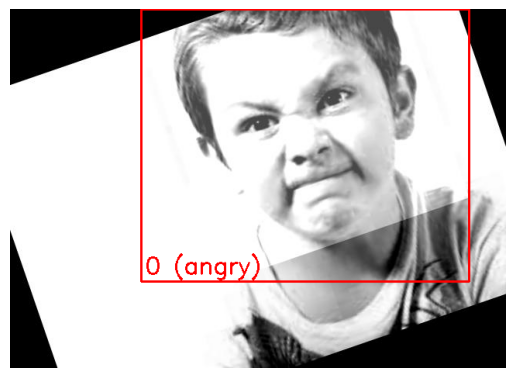

In [75]:
# Choose a single image and get bounding box info (label)
img_path = DATASET_PATH / "train/images" / "z_jpeg.rf.5b03df7d7bb26170444dbe50579fe67c.jpg"
label_path = DATASET_PATH / "train/labels" / (img_path.stem + ".txt")

# Load image
img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

# Get a tensor version of the image
img_tensor = img_to_tensor(img)

# Load bounding boxes
bboxes = []
with open(label_path) as f:
    for line in f:
        bboxes.append(list(map(float, line.strip().split())))
bboxes = np.array(bboxes, dtype=np.float32)

# Convert bounding boxes to tensor (PyTorch will expect this format)
if len(bboxes) > 0:
    labels = torch.tensor(bboxes)
else:
    labels = torch.zeros((0, 5))

# Show image
visualize_sample(img_tensor, labels, class_names)

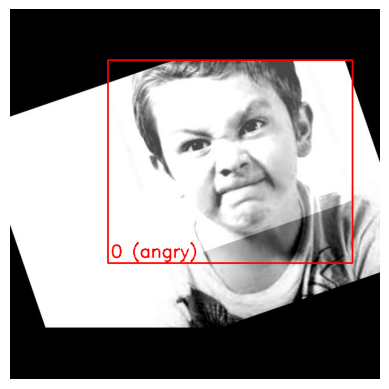

In [76]:
# Get image dimensions
img_h = img.shape[0]
img_w = img.shape[1]

# Preprocess the above image
target_w = 640
target_h = 640
img_proc, scale, pad_left, pad_top = preprocess_image(img, target_w, target_h)

# Get a tensor version of the image
img_tensor = img_to_tensor(img_proc)

# Scale the associated bounding boxes to match the letterboxed image
bboxes_proc = adjust_bboxes_yolo(
    bboxes,
    img_w,
    img_h,
    target_w, 
    target_h,
    scale, 
    pad_left, 
    pad_top
)

# Convert bounding boxes to tensor (PyTorch expects this format)
if len(boxes_proc) > 0:
    labels = torch.tensor(bboxes_proc)
else:
    labels = torch.zeros((0, 5))

# Show image
visualize_sample(img_tensor, labels, class_names)

In [80]:
class YoloDetectionDataset(Dataset):
    """
    YOLO-format dataset loader with grayscale replication and letterbox resizing.
    Each label file has one object per line: class xc yc w h (normalized).
    """
    def __init__(self, images_dir, labels_dir, width=640, height=640, transform=None):
        self.image_paths = sorted([
            os.path.join(images_dir, f)
            for f in os.listdir(images_dir)
            if f.endswith((".jpg", ".png"))
        ])
        self.labels_dir = labels_dir
        self.width = width
        self.height = height
        self.transform = transform

    def __len__(self):
        """Get number of items"""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Retrieve a single item"""
        # Construct path
        img_path = self.image_paths[idx]
        label_path = os.path.join(
            self.labels_dir,
            os.path.splitext(os.path.basename(img_path))[0] + ".txt"
        )

        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        # Get image dimensions
        img_h = img.shape[0]
        img_w = img.shape[1]

        # Preprocess (letterbox) the image
        img_proc, scale, pad_left, pad_top = preprocess_image(img, self.width, self.height)

        # Get a tensor version of the image
        img_tensor = img_to_tensor(img_proc)

        # Load bounding boxes
        bboxes = []
        with open(label_path) as f:
            for line in f:
                bboxes.append(list(map(float, line.strip().split())))
        bboxes = np.array(bboxes, dtype=np.float32)

        # Scale the associated bounding boxes to match the letterboxed image
        bboxes_proc = adjust_bboxes_yolo(
            bboxes,
            img_w,
            img_h,
            self.width, 
            self.height,
            scale, 
            pad_left, 
            pad_top
        )
        
        # Convert bounding boxes to tensor (PyTorch expects this format)
        if len(bboxes_proc) > 0:
            labels = torch.tensor(bboxes_proc)
        else:
            labels = torch.zeros((0, 5))

        return img_tensor, labels

In [81]:
# Create an instance of our dataset loader
train_dataset = YoloDetectionDataset(
    images_dir=DATASET_PATH / "train/images",
    labels_dir=DATASET_PATH / "train/labels",
    width=640,
    height=640,
)
print("Number of samples:", len(train_dataset))

Number of samples: 2568


Image tensor shape: torch.Size([3, 640, 640])
Labels tensor:
 tensor([[3.0000, 0.5859, 0.3094, 0.3547, 0.5781]])


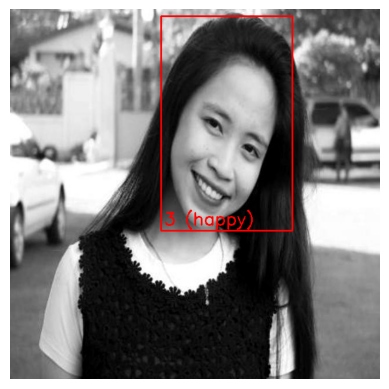

In [102]:
# Load an image from the dataset
idx = 2000
img, labels = train_dataset[idx]
print("Image tensor shape:", img.shape)
print("Labels tensor:\n", labels)

# Show the image with bounding box(es)
img, labels = train_dataset[idx]
visualize_sample(img, labels, class_names)

## Choo choo train